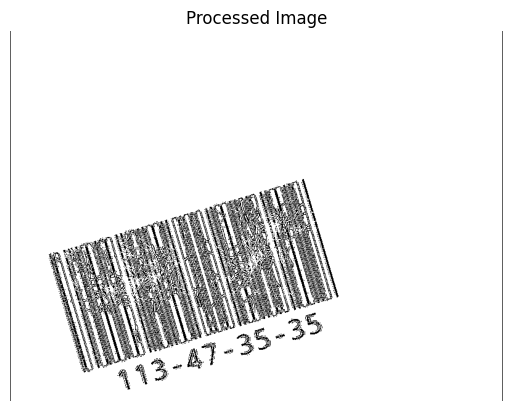

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image with a corrected file path
img = cv2.imread("E://Study//Senior 1//Fall 24//Computer Vision//Project//barcode_vision//Test Case Images//11 - bayza 5ales di bsara7a.jpg", cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded correctly
if img is None:
    print("Error: Image not found!")
else:
    # Step 1: Apply FFT
    img_float = np.float32(img)
    f = np.fft.fft2(img_float)
    fshift = np.fft.fftshift(f)  # Shift zero frequency components to the center

    # Step 2: Create a mask to filter out the sine wave (specific frequency components)
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    # Example: A simple mask to remove a specific frequency range (you can fine-tune this)
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 0  # Modify this to match your sine wave frequency

    # Step 3: Apply the mask to filter out the sine wave components
    fshift = fshift * mask

    # Step 4: Perform Inverse FFT to get the image back
    f_ishift = np.fft.ifftshift(fshift)  # Reverse the shift
    img_back = np.fft.ifft2(f_ishift)  # Inverse FFT
    img_back = np.abs(img_back)  # Take the absolute value (since the result may have small imaginary parts)

    # Step 5: Normalize the result to the correct range
    img_back = np.uint8(np.clip(img_back, 0, 255))
    # Invert the image colors
    img_back = cv2.bitwise_not(img_back)

    # Increase sharpness using a sharpening filter
    sharpening_filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    img_back = cv2.filter2D(img_back, -1, sharpening_filter)

    # Step 6: Apply Otsu's thresholding
    _, processed_image = cv2.threshold(img_back, 0, 255, cv2.THRESH_OTSU)

    # Apply edge detection using Canny
    edges = cv2.Canny(processed_image, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for filling contours
    mask = np.zeros_like(processed_image)

    # Fill contours
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, (255), -1)
        cv2.fillPoly(mask, pts=[contour], color=(255))
    # Apply mask to the original image
    result = cv2.bitwise_and(processed_image, mask)

    # Increase sharpness again
    processed_image = cv2.filter2D(processed_image, -1, sharpening_filter)

    # Save the image
    cv2.imwrite("processed_image.jpg", processed_image)

    # Step 7: Display the result
    plt.imshow(processed_image, cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    plt.show()


In [19]:
def show_image(title, image):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def crop_barcode(image_path, output_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 200, 255)

    # Apply morphological operations to close gaps in the edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    # Show the edged image
    show_image("Edged Image", edged)
    show_image("Closed Image", closed)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area, keeping only the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    barcode_contour = None

    # Loop over the contours to find the one that likely represents the barcode
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If the approximated contour has four points, we can assume we have found the barcode
        if len(approx) == 4:
            barcode_contour = approx
            break

    if barcode_contour is not None:
        # Get the points of the contour (in order of top-left, top-right, bottom-right, bottom-left)
        points = barcode_contour.reshape(4, 2)

        # Order the points in a consistent way
        points = sorted(points, key=lambda x: x[0])
        (tl, tr) = sorted(points[:2], key=lambda x: x[1])  # top-left, top-right
        (bl, br) = sorted(points[2:], key=lambda x: x[1])  # bottom-left, bottom-right

        # The ordered points for the perspective transform
        ordered_points = np.array([tl, tr, br, bl], dtype="float32")

        # Define the width and height of the new image (horizontal rectangle)
        width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
        height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

        # Define the destination points for the perspective transform (a rectangular region)
        destination_points = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype="float32")

        # Compute the perspective transform matrix
        matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)

        # Apply the perspective transform to straighten the barcode region
        straightened_image = cv2.warpPerspective(image, matrix, (width, height))

        # Check if the image is taller than it is wide
        if straightened_image.shape[0] > straightened_image.shape[1]:
            # Rotate the image to make it horizontal
            straightened_image = cv2.rotate(straightened_image, cv2.ROTATE_90_CLOCKWISE)

        # Show the straightened barcode
        show_image("Straightened Barcode", straightened_image)

        # Save the straightened image
        cv2.imwrite(output_path, straightened_image)
        print(f"Straightened image saved to {output_path}")
    else:
        print("No barcode detected")

In [ ]:
edges = cv2.Canny(img, 100, 200)
cv2.imshow('Edges', edges)
cv2.waitKey(0)
cv2.destroyAllWindows()
edge= cv2.bitwise_not(edges)
cv2.imshow('Edges', edge)
cv2.waitKey(0)
cv2.destroyAllWindows()


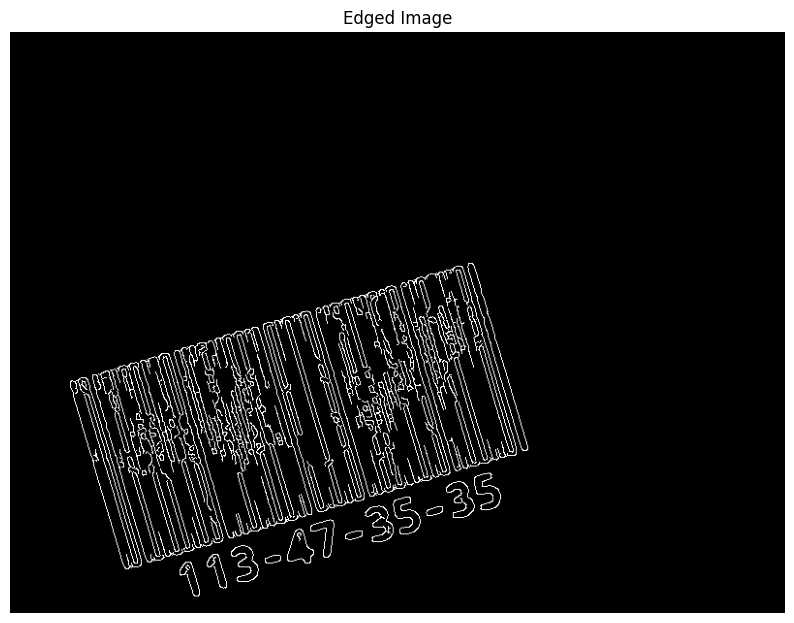

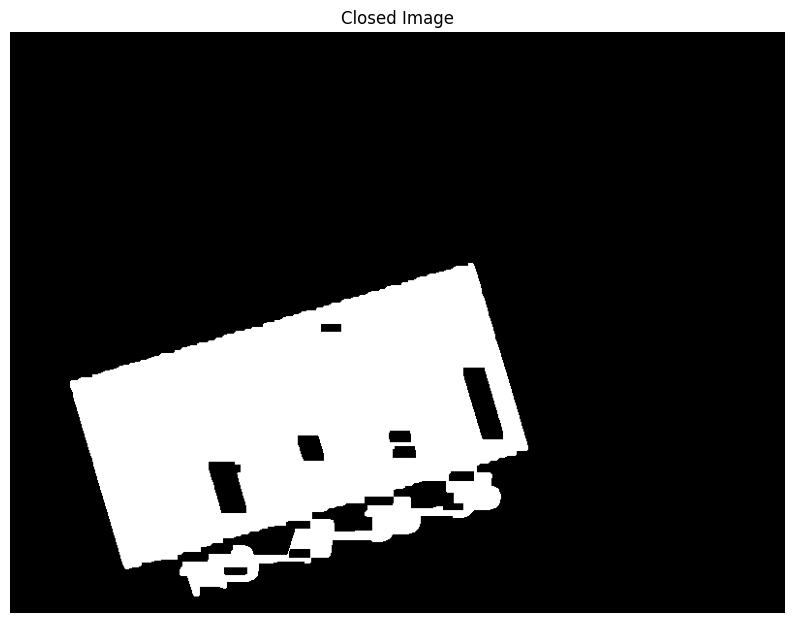

No barcode detected


In [ ]:
#call the function
crop_barcode("processed_image.jpg", "cropped_image.jpg")